In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('ConvergedStats (Nov 28 2021).csv', index_col=False)

In [3]:
#round the values
df = df.round()

# get only CPID/project data
df = df[df.StatsType == 'byCPIDbyProject']
df.sort_values(by='CPID', inplace=True)

# get cpids
cpids = df[df.StatsType == 'byCPIDbyProject']['CPID']
cpids_unique = cpids.unique()

# get projects
projects = df.Project.dropna().unique()

# make a dataframe for the RACs of every CPID on every project
cpids_racs = pd.DataFrame(data=0, index=cpids_unique, columns=projects)

# fill in cpids_racs with the RAC of every CPID on every project
for project in cpids_racs.columns:
    temp_cpids = df[df.Project == project]['CPID']
    cpids_racs.loc[temp_cpids, project] = df.loc[df.Project == project, 'RAC'].values
    
# only consider crunchers that crunch a single project
single_project_cruncher_mask = cpids_racs.astype(bool).sum(axis=1) == 1
cpids_racs = cpids_racs[single_project_cruncher_mask]

# only consider projects that have some minumum number of crunchers
min_threshold_project_mask = cpids_racs.astype(bool).sum(axis=0) >= 10
cpids_racs = cpids_racs.loc[:, min_threshold_project_mask]


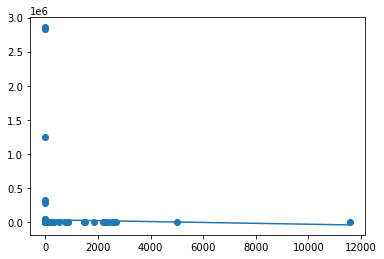

In [4]:
# two dimensional example

current_regressor = 'rosetta@home'
current_regressand = 'World_Community_Grid'
model = LinearRegression().fit(cpids_racs[current_regressor].values.reshape(-1,1), cpids_racs[current_regressand].values)

temp_line = np.arange(0, int(cpids_racs[current_regressor].values.max()), 1) * model.coef_ + model.intercept_

plt.scatter(cpids_racs[current_regressor], cpids_racs[current_regressand])
plt.plot(range(int(cpids_racs[current_regressor].values.max())), temp_line.T)
plt.show()

In [5]:
# more general example

reduced_projects = cpids_racs.columns
regressand = 'rosetta@home'
regressors = np.setdiff1d(reduced_projects, regressand)
# remove collatz conjecture, since it completely skews the graphic and renders it pointless
regressors = np.setdiff1d(regressors, 'collatz_conjecture')

cpids_racs_reduced = cpids_racs.copy()

In [6]:
model2 = LinearRegression().fit(cpids_racs_reduced[regressors], cpids_racs_reduced[regressand])
model2.coef_, model2.intercept_
values = - np.repeat(model2.intercept_, len(model2.coef_)) / model2.coef_

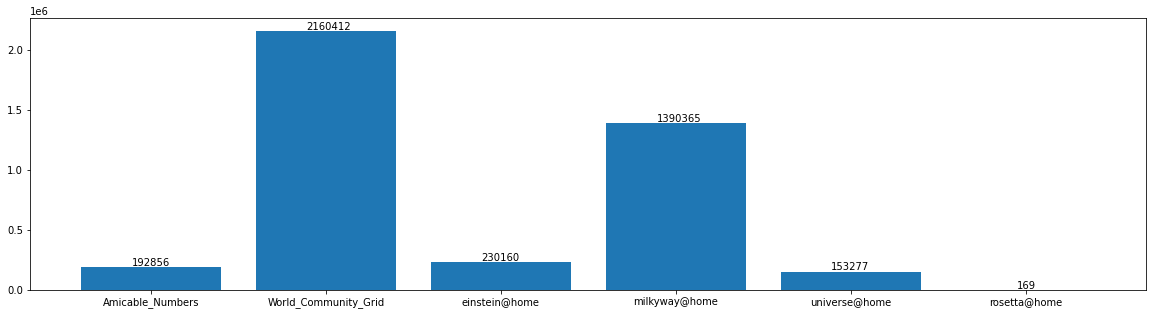

In [7]:
fig, ax = plt.subplots()
ax.bar(regressors, values)
ax.bar(regressand, model2.intercept_)

xlocs, xlabs = plt.xticks()
xlocs=[i+1 for i in range(0,10)]
xlabs=[i/2 for i in range(0,10)]
for i, value in enumerate(values):
    plt.text(xlocs[i] - 1.11, value + 10**4, int(value))
plt.text((len(values) + 1) - 1.05, model2.intercept_ + 10**4, int(model2.intercept_))

fig.set_size_inches(20, 5)

plt.savefig('./images/Calculated Equivalence Ratio.png', bbox_inches='tight')